In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sparg
import sparg_with_inf as spinf
import sys
import tskit
import msprime
import warnings
from importlib import reload
import matplotlib as mpl 
mpl.use("Qt5Agg")


# Code for generating the data files

## 1. Data file for dispersal rates when max mating distance $d = \infty $

In [ ]:
ts = tskit.load("slim_0.25rep1sigma.trees")

sd = 1
print(sd)
np.random.seed(sd)
keep_nodes = list(np.random.choice(ts.samples(), 10, replace=False))

ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
ts_filtered, filtered_maps = spinf.simplify_with_recombination(ts=ts_sim)
ts_chopped = spinf.chop_arg(ts_filtered,10000)
#FullARG = spinf.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
print("Step")

outfile = open("slim_0.25rep1sigma_inf_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")
i = 0
ts_breaks = ts_chopped.breakpoints(as_array=True)
print(len(ts_breaks))
FI1_trees = []
FI2_trees = []
sigma_trees = [] 
for (bp_i,bp) in enumerate(ts_breaks):
    if bp_i > 0:
         if bp_i%100 == 0 or bp_i == 1 :
            print(sd, bp_i)
            if bp_i in range(0,1551,100):
                print(sd, bp_i)
            ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
            ts_short_sim, maps_short_sim = spinf.simplify_with_recombination(ts=ts_short)
            ts_short_attached = spinf.chop_arg(ts=ts_short, time = ts_short.max_time )

            ts_tree = ts_short_attached.keep_intervals(intervals=[(ts_breaks[bp_i-1],bp)], simplify=False).trim() 
            ts_tree = spinf.chop_arg(ts=ts_tree,time= ts_tree.max_time)

            PartialARG = spinf.SpatialARG(ts=ts_short_attached,dimensions=2, verbose=False)
            inf_dispersal_rate = PartialARG.inf_dispersal_rate_matrix
            FI1 = PartialARG.inf_fishers_information_1
            FI2 = PartialARG.inf_fishers_information_2 

            Tree = spinf.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)

            inf_dispersal_rate_tree = Tree.inf_dispersal_rate_matrix
            FI1_tree = Tree.inf_fishers_information_1 
            FI2_tree = Tree.inf_fishers_information_2

            FI1_trees += [ inf_dispersal_rate_tree[0][0]**2*FI1 ]
            FI2_trees += [ inf_dispersal_rate_tree[0][0]**3*FI2 ]
            sigma_trees += [ inf_dispersal_rate_tree[0][0] ]

            sigma_avg = np.average(sigma_trees)
            FI1_avg = np.sum(FI1_trees)/(sigma_avg**2)
            FI2_avg = np.sum(FI2_trees)/(sigma_avg**3)

            outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(inf_dispersal_rate[0][0]) + " " + str(inf_dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg)  + "\n")


outfile.close()

## 2. Code to generate dispersal rates using the windowing approach

In [ ]:
ts = tskit.load("slim_0.25rep1sigma.trees")

for sd in range(1):
    print(sd)
    np.random.seed(sd)
    keep_nodes = list(np.random.choice(ts.samples(), 10, replace=False))
    
    ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
    ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
    ts_chopped = sparg.chop_arg(ts_filtered,10000)
    FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
    locations_of_nodes, var_nodes = locate_nodes(nodes = range(ts_chopped.num_nodes), SpARG = FullARG)
    dispersal_rate_treewise, average_dispersal_rate_treewise = average_dispersal_treewise(ts=ts_chopped, locations_of_nodes = locations_of_nodes)
    print("Step")
    
    outfile = open("short_slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")
    i = 0
    ts_breaks = ts_chopped.breakpoints(as_array=True)
    print(len(ts_breaks))
    FI1_trees = []
    FI2_trees = []
    sigma_trees = [] 
    for (bp_i,bp) in enumerate(ts_breaks):
        if bp_i > 0 and bp_i <100:
            print(sd, bp_i)
            ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
            ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
            ts_short_attached = sparg.chop_arg(ts=ts_short, time = ts_short.max_time )

            ts_tree = ts_short_attached.keep_intervals(intervals=[(ts_breaks[bp_i-1],bp)], simplify=False).trim() 
            ts_tree = sparg.chop_arg(ts=ts_tree,time= ts_tree.max_time)

            PartialARG = sparg.SpatialARG(ts=ts_short_attached,dimensions=2, verbose=False)
            dispersal_rate = PartialARG.dispersal_rate_matrix
            FI1 = PartialARG.fishers_information_1
            FI2 = PartialARG.fishers_information_2 
            loc_nodes, var_nodes = locate_nodes(nodes = range(ts_short_attached.num_nodes), SpARG = PartialARG)
            disp_ARG, avg_disp_ARG = average_dispersal_treewise(ts=ts_short_attached, locations_of_nodes = loc_nodes)
                
            Tree = sparg.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)

            dispersal_rate_tree = Tree.dispersal_rate_matrix
            FI1_tree = Tree.fishers_information_1 
            FI2_tree = Tree.fishers_information_2

            FI1_trees += [ dispersal_rate_tree[0][0]**2*FI1 ]
            FI2_trees += [ dispersal_rate_tree[0][0]**3*FI2 ]
            sigma_trees += [ dispersal_rate_tree[0][0] ]

            sigma_avg = np.average(sigma_trees)
            FI1_avg = np.sum(FI1_trees)/(sigma_avg**2)
            FI2_avg = np.sum(FI2_trees)/(sigma_avg**3)

            if bp_i > 21 and bp_i < len(ts_breaks)-21: 
                W20_ts = ts_chopped.keep_intervals(intervals=[(ts_breaks[bp_i-21],ts_breaks[bp_i+20])], simplify=False).trim() 
                W20_ts = sparg.chop_arg(ts=W20_ts,time= W20_ts.max_time)
                W20_ARG = sparg.SpatialARG(ts=W20_ts, dimensions=2,verbose=False)
                W20_disp = W20_ARG.dispersal_rate_matrix
                loc_nodes, var_nodes = locate_nodes(nodes = range(W20_ts.num_nodes), SpARG = W20_ARG)
                disp_W20_treewise, avg_disp_W20_treewise = average_dispersal_treewise(ts=W20_ts, locations_of_nodes = loc_nodes)
                outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg) + " " + str(dispersal_rate_treewise[bp_i][0][0])+ " " + str(dispersal_rate_treewise[bp_i][1][1]) + " " + str(average_dispersal_rate_treewise[bp_i][0][0])+ " " + str(average_dispersal_rate_treewise[bp_i][1][1]) + " " + str(avg_disp_ARG[-1][0][0])+ " " + str(avg_disp_ARG[-1][1][1]) + " " +str(W20_disp[0][0]) + " " +str(W20_disp[1][1]) + " " + str(avg_disp_W20_treewise[-1][0][0]) + " " + str(avg_disp_W20_treewise[-1][1][1]) + "\n")
            else: 
                outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg) + " " + str(dispersal_rate_treewise[bp_i][0][0])+ " " + str(dispersal_rate_treewise[bp_i][1][1]) + " " + str(average_dispersal_rate_treewise[bp_i][0][0])+ " " + str(average_dispersal_rate_treewise[bp_i][1][1]) + " " + str(avg_disp_ARG[-1][0][0])+ " " + str(avg_disp_ARG[-1][1][1]) + "\n")

outfile.close()


# Code to generate Supplemental Figure S3

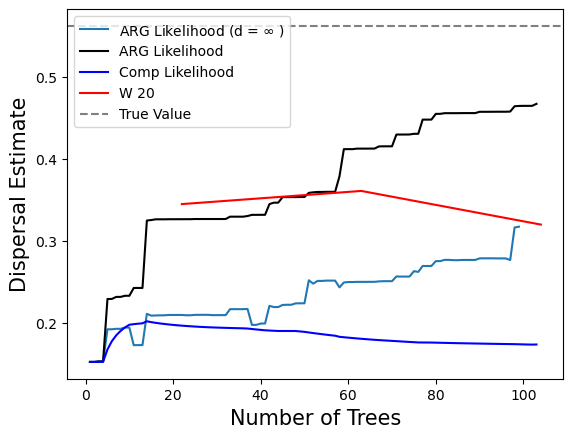

In [6]:
%matplotlib inline

dispersal_1 = np.loadtxt("short_slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_0.txt") 
dispersal_1_inf = np.loadtxt("slim_0.25rep1sigma_inf_dispersalrateestimates_seqlen_100_chopped_10000_rep_0.txt")

w20 = dispersal_1[21:len(dispersal_1[:121,0]),13] 
w20_disjoint = w20[::41]
w20_comp = [ np.average(w20_disjoint[:i+1]) for i in range(len(w20_disjoint)) ]
w20_x = dispersal_1[21:len(dispersal_1[:121,0]),0][::41] 


plt.plot(dispersal_1_inf[:,0],dispersal_1_inf[:,2], label = 'ARG Likelihood (d = $\infty$ )')

plt.plot(dispersal_1[:103,0], dispersal_1[:103,2], color='black', label = "ARG Likelihood")
plt.plot(dispersal_1[:103,0], dispersal_1[:103,5], color = 'blue', label = "Comp Likelihood")
#plt.plot(dispersal_1[:103,0], dispersal_1[:103,11], color = 'green', label = "ARG-constrained \nComp Likelihood")
plt.plot(w20_x, w20_comp, color = 'red', label = "W 20")

#plt.axhline(y=0.25**2,label = "True Value", linestyle = '--', color = 'grey')
plt.axhline(y=0.25**2+0.5,label = "True Value", linestyle = '--', color = 'grey')

plt.legend()
plt.xlabel("Number of Trees", fontsize = 15)
plt.ylabel("Dispersal Estimate", fontsize = 15)
plt.show()

